# Transducing Language Models

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from transduction import FST, FSA, EPSILON, examples, Precover
from transduction.enumeration import prioritized_enumeration, crude_importance_sampling, importance_sampling, logsumexp
from transduction.viz import display_table

import numpy as np

Notes

* I would favor moving to a general "prioritize however you see fit" design rather than hardcoding the LM prefix probability as the only design.

* For example, it may be possible to view trimming (or approximate trimming from co-accessibility in a coarse-grained precover) as a kind of priorization heuristic.
  
* I would prefer to defer rather than prune so that we have good methods for recovering from dead ends.

* I like to think of the enumeration algorithm as a prioritized materialization for the cross-production construction of the LM and the FST.  In the case of a neural language model, the LM's state space is the infinitely large and degenerate space of string prefixes.  We can contrast that with the case of a PFsA, where states come from a finite set.  How about PCFGs?  (The Bar-Hillel construction creates states of the form `(i,X,j)` where `i` and `j` are states of the automaton and `X` is a nonterminal in the PCFG.  It seems a little different that we triplets rather than pairs, but maybe there is an elegant way to reconcile this.) 

* It would be really nice if our enumeration method recovered exact algorithms when run on models with finitely many states (e.g., PCFG language models).

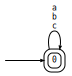

In [4]:
fst = examples.replace([('a', 'a'), ('b', 'b'), ('c', 'c')])
fst

In [5]:
from genparse import EarleyLM, EOS

In [ ]:
lm = EarleyLM.from_string("""

.5: S -> a S
.4: S -> b S
.1: S -> c

""")
lm.logp_next = lambda x: {k: np.log(v) if v > 0 else float('-inf') for k, v in lm.p_next(x).items()}

In [ ]:
class StatefulLM:
    """Wraps a stateless LM (e.g., genparse.EarleyLM) into the stateful
    interface expected by prioritized_enumeration.

    The wrapped LM must support ``p_next(context) -> dict-like`` returning
    next-token probabilities given a context sequence.

    This wrapper provides:
      - ``.eos``       — the end-of-sequence token
      - ``.logp_next`` — dict mapping next tokens to log-probabilities
      - ``>> token``   — returns a new state with *token* appended to context

    Example::

        from genparse import EarleyLM, EOS
        lm = StatefulLM(EarleyLM.from_string("..."), eos=EOS)
    """

    def __init__(self, lm, eos, context=()):
        self._lm = lm
        self._eos = eos
        self._context = context

    @property
    def eos(self):
        return self._eos

    @property
    def logp_next(self):
        p = self._lm.p_next(self._context)
        return {k: np.log(v) if v > 0 else float('-inf')
                for k, v in p.items()}

    def __rshift__(self, token):
        return StatefulLM(self._lm, self._eos, self._context + (token,))

    def __repr__(self):
        return f'StatefulLM({list(self._context)})'

In [26]:
prioritized_enumeration(StatefulLM(lm, EOS), fst, 'abc', max_steps=50)

pop: Item(0.000, {(0, '')}, StatefulLM([]))
pop: Item(-0.693, {(0, 'a')}, StatefulLM(['a']))
pop: Item(-1.609, {(0, 'ab')}, StatefulLM(['a', 'b']))
pop: Item(-3.912, {(0, 'abc')}, StatefulLM(['a', 'b', 'c']))


In [27]:
prioritized_enumeration(StatefulLM(lm, EOS), fst, 'aa', max_steps=100)

pop: Item(0.000, {(0, '')}, StatefulLM([]))
pop: Item(-0.693, {(0, 'a')}, StatefulLM(['a']))
pop: Item(-1.386, {(0, 'aa')}, StatefulLM(['a', 'a']))


In [28]:
importance_sampling(StatefulLM(lm, EOS), fst, 'abc').sample()

Item(-3.912, {(0, 'abc')}, StatefulLM(['a', 'b', 'c']))

In [29]:
importance_sampling(StatefulLM(lm, EOS), fst, 'aa').sample()

Item(-1.386, {(0, 'aa')}, StatefulLM(['a', 'a']))